<a href="https://colab.research.google.com/github/dominikjagoda/my-first/blob/main/cw6deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. 


Naszym zadaniem jest zbudować jak najbardziej wydajny program do klasyfikacji zdjęć uczący się na bardzo małej próbce danych. Proponuję użyć rozmiarów próbek treningowych:

1.    500 obrazków
2.   1000 obrazków
3.   5000 obrazków.
Za każdym razem używamy 10 000 przypadków jako zbioru testowego. Selekcjonujemy z danych tylko trzy klasy obrazków: samochody, ptaki i samoloty (żeby było łatwiej).

To jest tylko szkielet programu - dokonuje klasyfikacji, ale jest daleki od optimum.

**Państwa zadaniem jest:**

1.   Dodać modyfikację obrazów (augmentacja). Jest to zrobione w formie szkieletowej, wariancje parametrów wynoszą zero. Proponuję na początek zmieniać (ta sama zmienna dla dwóch przesunięć i powiększenia):
  *   rotation_range=rotation_range,
  *    width_shift_range=shift_range,
  *    height_shift_range=shift_range,
  *    zoom_range=shift_range  
Oczywiście można potem zwiększyć liczbę optymalizowanych parametrów. 
2. Dodać K-folding np. 5-krotny. Walidację przeprowadamy na 1/5 zbioru treningowego, uczenie na 4/5. Końcowy klasyfikator jest uśrednionym klasyfikatorem z tych pięciu.
3. Dodać optymalizację. Optymalizujemy w pierwszym podejściu trzy zmienne:
  *   rotation_range
  *   shift_range
  *   num_filters - liczba filtrów w warstwie ukrytej.

  Optymalizujemy **bez użycia** danych testowych, tylko posiłkując się danymi walidacyjnym z k-folding. Można optymalizować np. średnią dokładność (accuracy) wszystkich pięciu sieci z k-foldingu. Optymalizację można najpierw prowadzić dla 5 kroków, jak program będzie już działać to dla 30-50 kroków
4. Dla optymalnych parametrów przeprowadzić końcowy trening, narysować "accuracy" dla wszystkich sieci z k-foldingu i zbudować końcowy klasyfikator (średnia z wszystkich klasyfikatorów z k-foldingu).
5. Znaleźć "accuracy" oraz "confusion matrix" dla końcowego klasyfikatora. 
6. Można powtórzyć dla innej liczby obrazków w zbiorze treningowym. 

7. Można optymalizować także:
*  drop_dense2
*  drop_conv2
*  liczbę "bloków" w sieci konwolucyjnej (obecnie trzy)

8. UWAGA: sieć zoptymalizowana dla małej liczby obrazków treningowych może nie być optymalna dla ich dużej liczby

Dużo pracy, ale to kompletny projekt!!!






In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# select three classes only and limited number of events

N_TRAIN_EXAMPLES = 500  # very little!!!!
#N_TEST_EXAMPLES = 100
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


x_train = x_train[:N_TRAIN_EXAMPLES] # only N_TRAIN_EXAMPLES
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



170500096/170498071 [==============================] - 2s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(500, 32, 32, 3)
(500, 1)
(3000, 32, 32, 3)
(3000, 1)


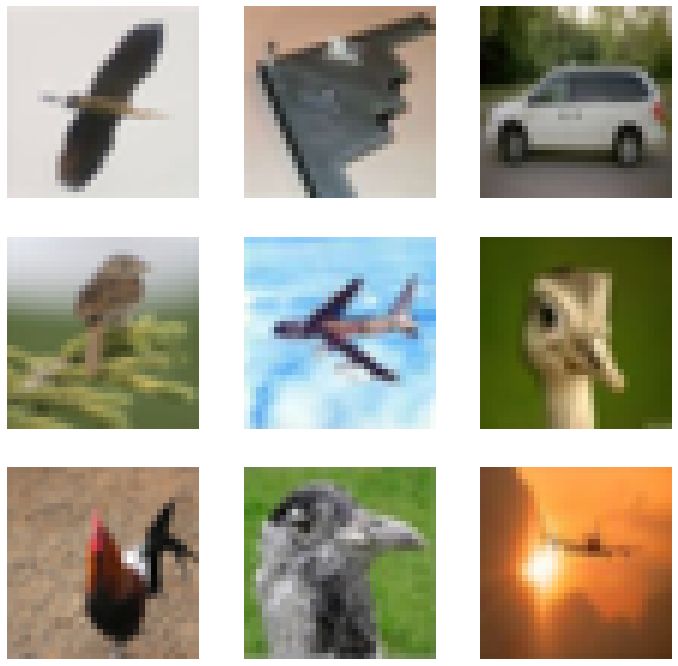

In [3]:
# save x_test images
xx_test = x_test
yy_test = y_test




fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    #print(x_train[i].shape)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation
datagen = ImageDataGenerator( 
    rotation_range=30,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25
    )
datagen.fit(x_train)

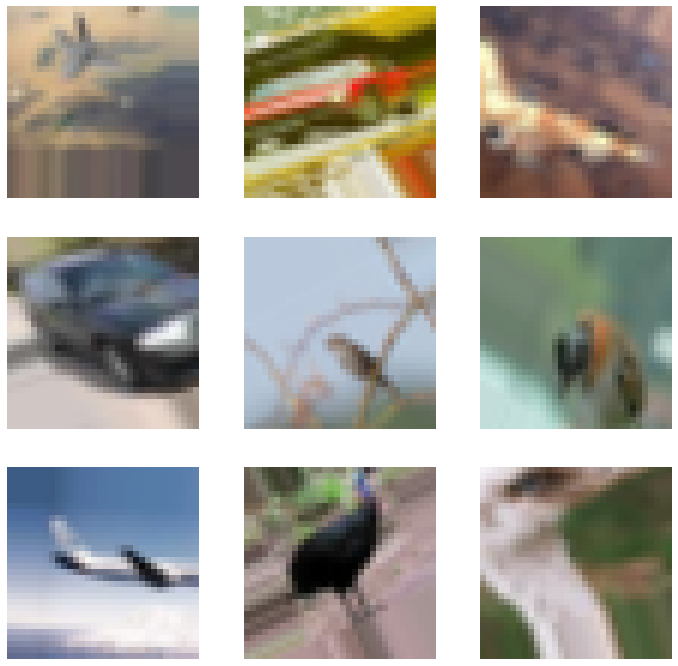

In [5]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

   

Augmentation of a single image

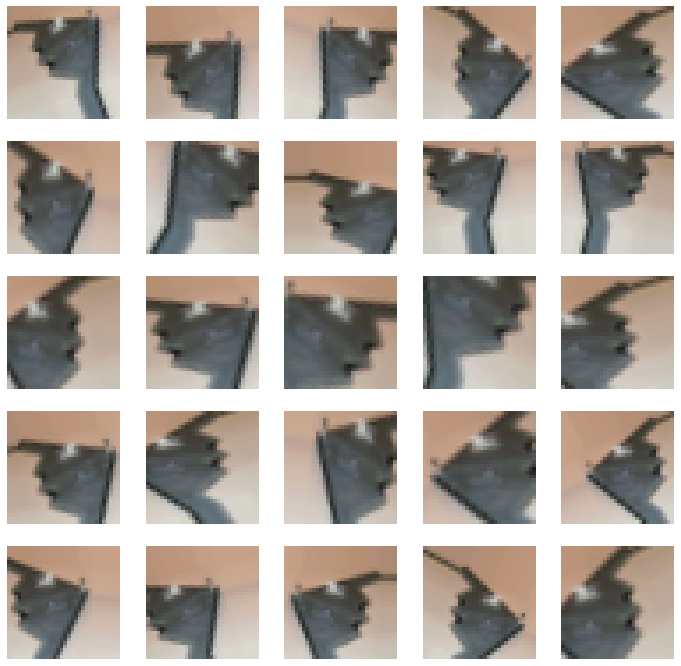

In [6]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()
    


In [7]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
#input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (500, 32, 32, 3)
500 train samples
3000 test samples


In [8]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [9]:
 # labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

# **Optuna & K-FOLDING optimization**





# **Create convolutional network**

In [10]:
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

# **Fit convolutional network**

In [11]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val, epochs):

  # train with image augmentation

  #es = EarlyStopping(
  #  monitor="val_accuracy",
  #  patience=60,
  #  verbose=1
  #)

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=epochs, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

# **Evaluate model with k-folding**

In [12]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32, epochs=150):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # create model
    model = create_model(num_filters)
    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
    history, model = fit_model(model, datagen, trainX, trainY, testX, testY, epochs)
    # evaluate model
    acc = model.evaluate(testX, testY, verbose=0)[1]
    print('Folding, acc =  %.3f' % (acc * 100.0))
		# stores scores
    scores.append(acc)
    histories.append(history)
    models.append(model)
  return scores, histories, models

#**Optimization using optuna or hyperopt**

In [13]:
# OPTUNA

! pip install optuna

import optuna

# or hyperopt
# import hyperopt

     |████████████████████████████████| 286kB 18.2MB/s 
     |████████████████████████████████| 163kB 48.9MB/s 
     |████████████████████████████████| 81kB 11.2MB/s 
     |████████████████████████████████| 481kB 55.9MB/s 
     |████████████████████████████████| 133kB 56.8MB/s 
     |████████████████████████████████| 112kB 52.1MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=84481905167743af856649412b904a56bcb59504528d8b1fa49716cf3508bf49
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=bfbcae51a9394128fc4b6f53867f44a2b7d029089f4b4e367bae0be5e9f98cda
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 s

# **Define objective**

In [14]:
# here define the hyperopt or optuna objective
#def objective(trial):
def objective():    
    


    # set up image augmentation
  num_filters = 32
  shift_range = 0
  rotation_range = 0    

  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


    #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters, epochs=150)

  return np.mean(scores)




# **Run the actual optimization**

In [15]:
# Here you should call the optuna/hyperopt optimization replacing the line below
objective()



Folding, acc =  82.000
Folding, acc =  72.000
Folding, acc =  74.000
Folding, acc =  81.000
Folding, acc =  74.000


0.7660000085830688

Print the results

In [16]:
#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#        print("    {}: {}".format(key, value))


# **Train with optimized parameters**

In [17]:



# here you should get parameters from optimization (the lines below should be updated)
num_filters = 32
rotation_range = 0
shift_range = 0.


# set up image augmentation
datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
)
datagen.fit(x_train)


#create and evaluate model
scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, epochs=200)

Folding, acc =  87.000
Folding, acc =  83.000
Folding, acc =  77.000
Folding, acc =  78.000
Folding, acc =  71.000


# **Make plots**

In [18]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



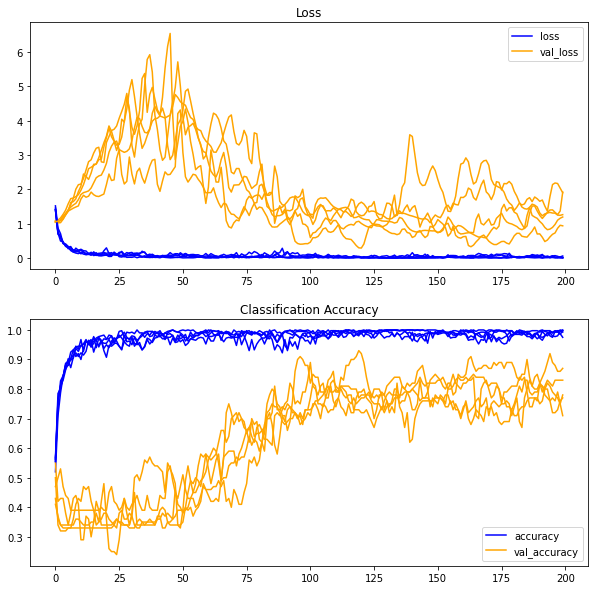

Accuracy: mean=79.200 std=5.455, n=5


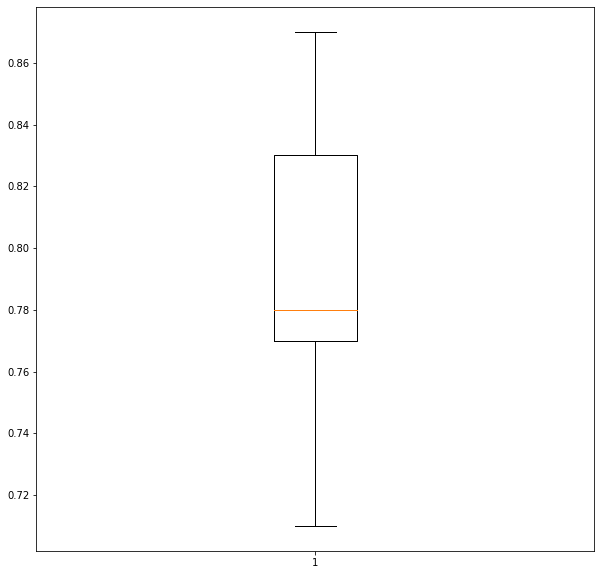

Scores:  [0.8700000047683716, 0.8299999833106995, 0.7699999809265137, 0.7799999713897705, 0.7099999785423279]


In [19]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks - build one classifier as an average of n models from variable models**

In [20]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)


score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  82.36666666666666 %


In [21]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[721 131 148]
 [ 41 931  28]
 [114  67 819]]




# **Plot images for the ensamble of models**

In [22]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test)-1)
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()


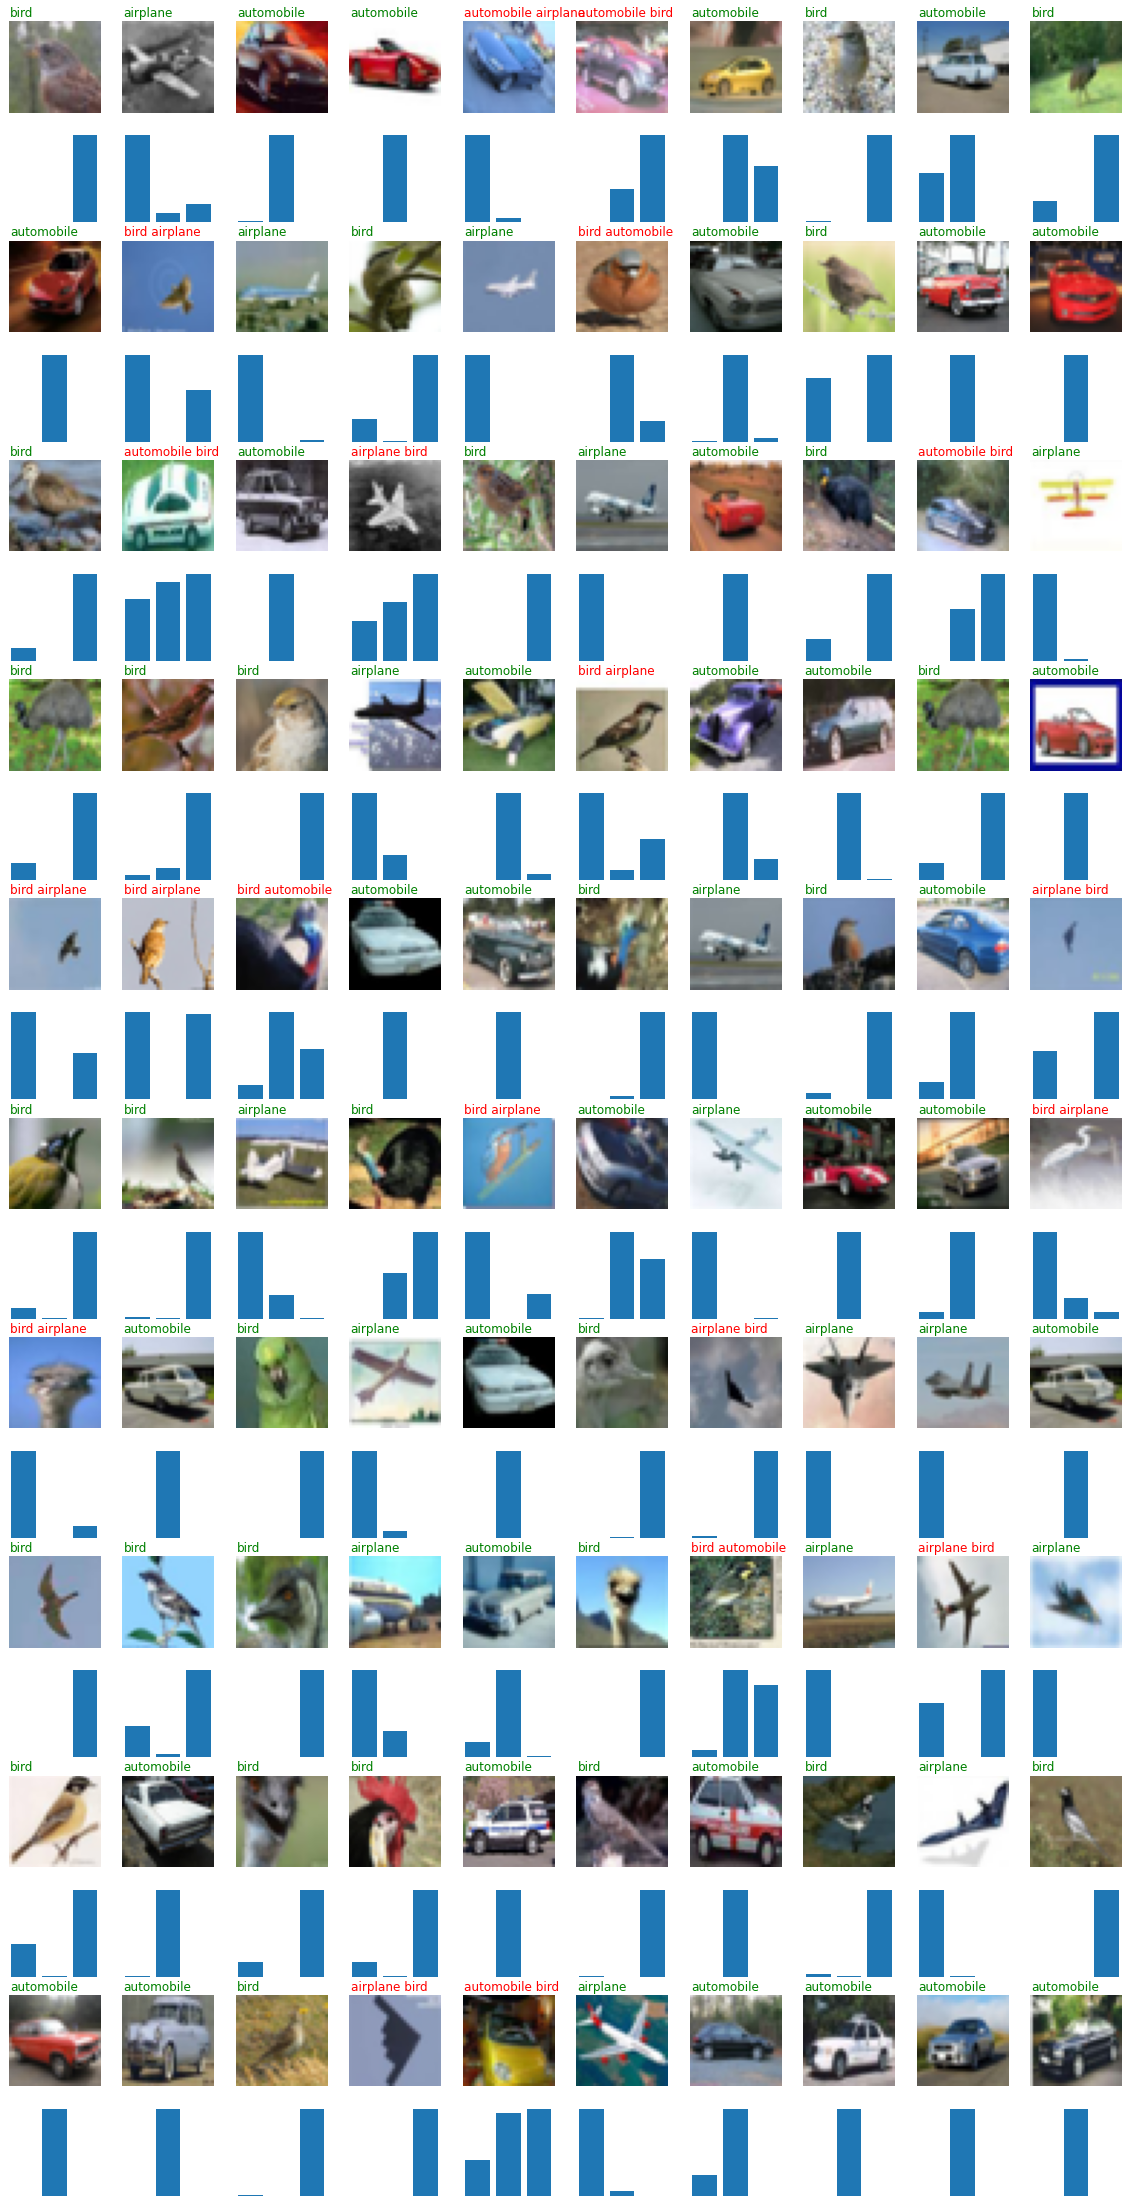

In [23]:
plot_images2(outcomes,summed)

[[721 131 148]
 [ 41 931  28]
 [114  67 819]]


## Visualizing the Optimization History

In [24]:
#from optuna.visualization import plot_optimization_history

#plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [25]:
#from optuna.visualization import plot_parallel_coordinate

#plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [26]:
#from optuna.visualization import plot_contour

#plot_contour(study)

## Visualizing Individual Parameters

In [27]:
#from optuna.visualization import plot_slice

#plot_slice(study)

## Visualizing Parameter Importances

In [28]:
#from optuna.visualization import plot_param_importances

#plot_param_importances(study)